# Association Analysis of Filipino Cuisine Ingredients


## Data loading and preview

### Read JSON files

In [1]:
import json
import os


def load_recipes(path="data/recipes"):
    """Combines all recipe data into a single list."""
    files = [file for file in os.listdir(path)]

    recipes = []
    for file in files:
        file_path = os.path.join(path, file)
        with open(file_path, encoding="utf-8") as f:
            recipe_data = json.load(f)
            recipes.extend(recipe_data)

    return recipes


recipes = load_recipes()
recipes[0]

{'link': 'https://www.allrecipes.com/recipe/128699/famous-chicken-adobo/',
 'name': 'Famous Chicken Adobo',
 'ingredients': ['2 tablespoons vegetable oil',
  '1 (3 pound) chicken, cut into pieces',
  '1 large onion, quartered and sliced',
  '2 tablespoons minced garlic',
  ' 2/3  cup low sodium soy sauce',
  ' 1/3  cup white vinegar',
  '1 tablespoon garlic powder',
  '2 teaspoons black pepper',
  '1  bay leaf'],
 'instructions': ['Step 1: Heat vegetable oil in a large skillet over medium-high heat. Cook chicken pieces until golden brown, 2 to 3 minutes per side. Transfer chicken to a plate and set aside.',
  'Step 2: Add onion and garlic to the skillet; cook until softened and brown, about 6 minutes.',
  'Step 3: Pour in soy sauce and vinegar and season with garlic powder, black pepper, and bay leaf.',
  'Step 4: Return chicken to pan, increase heat to high, and bring to a boil. Reduce heat to medium-low, cover, and simmer until chicken is tender and cooked through, 35 to 40 minutes.'

### Convert JSON to DataFrame

In [2]:
import pandas as pd


recipe_df = pd.DataFrame(recipes)
recipe_df.head()

,link,name,ingredients,instructions
0,https://www.allrecipes.com/recipe/128699/famou...,Famous Chicken Adobo,"[2 tablespoons vegetable oil, 1 (3 pound) chic...",[Step 1: Heat vegetable oil in a large skillet...
1,https://www.allrecipes.com/recipe/212994/pinak...,Pinakbet,"[3 tablespoons olive oil, 1 onion, chopped, 2...",[Step 1: Heat oil in a large pot over medium h...
2,https://www.allrecipes.com/recipe/204958/pork-...,Pork Sinigang,"[1 tablespoon vegetable oil, 1 small onion, ch...",[Step 1: Heat vegetable oil in a skillet over ...
3,https://www.allrecipes.com/recipe/270708/lumpi...,Lumpia in the Air Fryer,"[1 pound Italian hot sausage links, 1/2 cup f...",[Step 1: Remove casing from sausage and cook i...
4,https://www.allrecipes.com/recipe/212911/filip...,Filipino Beef Steak,"[4 pounds New York strip steak, sliced thin, 1...",[Step 1: Place sliced beef in a large bowl. Wh...


In [3]:
recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4244 entries, 0 to 4243
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   link          4244 non-null   object
 1   name          3898 non-null   object
 2   ingredients   3896 non-null   object
 3   instructions  3872 non-null   object
dtypes: object(4)
memory usage: 132.8+ KB


### Perform EDA on raw dataset

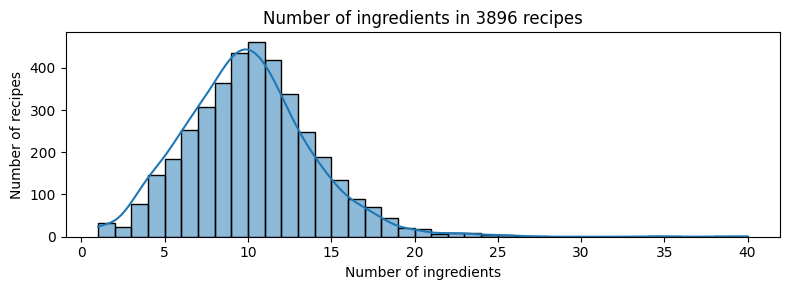

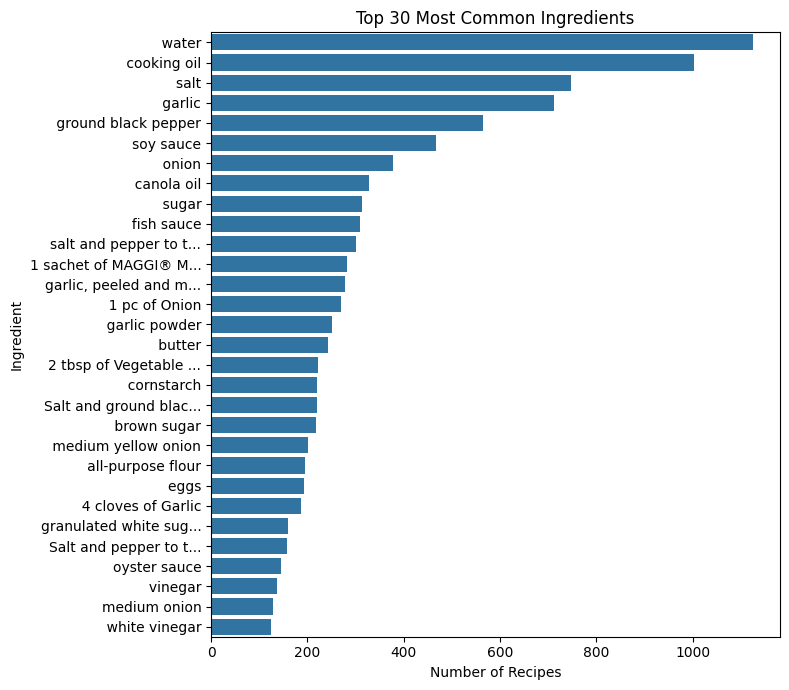

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns


def plot_ingredient_count_distribution(ingredient_series, figsize=(8, 3)):
    """Plots the distribution of the number of ingredients in recipes."""
    counts = ingredient_series.dropna().apply(len)
    plt.figure(figsize=figsize)
    sns.histplot(counts, kde=True, binwidth=1)
    plt.title(f"Number of ingredients in {len(counts)} recipes")
    plt.xlabel("Number of ingredients")
    plt.ylabel("Number of recipes")
    plt.tight_layout()
    plt.show()


def plot_common_ingredients(
    ingredient_series, n=30, most_common=True, figsize=(8, 7)
):
    """Plots the most or least common ingredients."""
    all_ingredients = ingredient_series.dropna().explode()
    ingredient_counts = all_ingredients.value_counts()

    if most_common:
        top_n_ingredients = ingredient_counts.head(n)
    else:
        top_n_ingredients = ingredient_counts.tail(n)

    ylabels = [
        f"{i[:20]:>20}{'...' if len(i) > 20 else ''}"
        for i in top_n_ingredients.index
    ]
    plt.figure(figsize=figsize)
    sns.barplot(x=top_n_ingredients.values, y=ylabels)
    indicator = "Most" if most_common else "Least"
    plt.title(f"Top {n} {indicator} Common Ingredients")
    plt.xlabel("Number of Recipes")
    plt.ylabel("Ingredient")
    plt.tight_layout()
    plt.show()


plot_ingredient_count_distribution(recipe_df.ingredients)
plot_common_ingredients(recipe_df.ingredients, n=30, most_common=True)

## Preprocessing


### Step 0. Remove recipes with no ingredients


In [5]:
def drop_empty_ingredients(recipe_df, column="ingredients"):
    """Drops rows with empty ingredients."""
    new_df = recipe_df.dropna(subset=[column])
    print(f"Dropped {recipe_df.shape[0] - new_df.shape[0]} rows.")
    return new_df


recipe_df = drop_empty_ingredients(recipe_df)

Dropped 348 rows.


In [6]:
def save_ingredients(ingredient_series, path):
    """Saves the ingredients to a TXT file."""
    os.makedirs(os.path.dirname(path), exist_ok=True)

    all_ingredients = ingredient_series.dropna().explode()
    data = sorted(all_ingredients.unique().astype(str))

    with open(path, "w", encoding="utf-8") as file:
        for ingredient in data:
            file.write(f"{ingredient.strip()}\n")


save_ingredients(
    recipe_df.ingredients,
    path="data/preprocess_output/0_raw.txt",
)

### Step 1. Clean ingredient format


In [7]:
import re

from tqdm import tqdm

tqdm.pandas()


def remove_parentheses(ingredient):
    """Removes parentheses and content from ingredient strings."""
    return re.sub(r" ?\([^)]+\)", "", ingredient)


def select_first_option(ingredient):
    """Selects the first option in a string with multiple options."""
    return ingredient.split(" or ")[0]


def clean_ingredient(ingredient):
    """Cleans an ingredient string."""
    ingredient = remove_parentheses(ingredient)
    ingredient = select_first_option(ingredient)
    return ingredient.lower().strip()


recipe_df["cleaned"] = recipe_df.ingredients.progress_apply(
    lambda x: [cleaned for i in x if (cleaned := clean_ingredient(i))]
)

100%|██████████| 3896/3896 [00:00<00:00, 110024.16it/s]


In [8]:
save_ingredients(
    recipe_df.cleaned,
    path="data/preprocess_output/1_cleaned.txt",
)

### Step 2. Lemmatize words and remove non-ingredient words


In [9]:
import spacy

nlp = spacy.load("en_core_web_lg")


def correct_noun_pos_tags(token):
    """Corrects the POS tags of specific tokens."""
    outliers = ["cauliflower", "baking"]
    if token.text in outliers:
        token.pos_ = "NOUN"
    return token


def lemmatize_nouns(ingredient):
    """Lemmatizes nouns in an ingredient string."""
    doc = nlp(ingredient)
    lemmas = []
    for token in doc:
        token = correct_noun_pos_tags(token)
        if (
            token.is_alpha
            and not token.is_stop
            and token.pos_ in ["NOUN", "PROPN"]
        ):
            lemmas.append(token.lemma_)
    return " ".join(lemmas)


recipe_df["lemmatized"] = recipe_df.cleaned.progress_apply(
    lambda x: [lemmatized for i in x if (lemmatized := lemmatize_nouns(i))]
)

100%|██████████| 3896/3896 [02:12<00:00, 29.36it/s]


In [10]:
save_ingredients(
    recipe_df.lemmatized,
    path="data/preprocess_output/2_lemmatized.txt",
)

### Step 3. Remove stop words related to culinary


In [11]:
input_file = "data/preprocess_input/stopwords.txt"
with open(input_file, encoding="utf-8") as file:
    stopwords = file.read().splitlines()


def filter_stopwords(text):
    """Filter out stopwords from a string."""
    words = []
    for word in text.split():
        if word not in stopwords:
            words.append(word)
    return " ".join(words)


recipe_df["filtered"] = recipe_df.lemmatized.progress_apply(
    lambda x: [filtered for i in x if (filtered := filter_stopwords(i))]
)

100%|██████████| 3896/3896 [00:00<00:00, 15840.33it/s]


In [12]:
save_ingredients(
    recipe_df.filtered,
    path="data/preprocess_output/3_filtered.txt",
)

### Step 4. Standardize ingredient names at word level


In [13]:
input_file = "data/preprocess_input/thesaurus.json"
with open(input_file, encoding="utf-8") as file:
    thesaurus = json.load(file)


def standardize_at_phrase_level(ingredient):
    """Replace words in an ingredient with standard names."""
    words = []
    for word in ingredient.split():
        words.append(thesaurus.get(word, word))
    return " ".join(words)


recipe_df["standardized_word"] = recipe_df.filtered.progress_apply(
    lambda x: [
        common_name
        for i in x
        if (common_name := standardize_at_phrase_level(i))
    ]
)

100%|██████████| 3896/3896 [00:00<00:00, 359997.54it/s]


In [14]:
save_ingredients(
    recipe_df.standardized_word,
    path="data/preprocess_output/4_standardized_word.txt",
)

### Step 5. Remove duplicate terms


In [15]:
def remove_duplicates(text):
    """Remove duplicate terms while preserving order."""
    seen = set()
    unique = []
    for word in text.split():
        if word not in seen:
            unique.append(word)
            seen.add(word)
    return " ".join(unique)


recipe_df["unique"] = recipe_df.standardized_word.progress_apply(
    lambda x: [unique for i in x if (unique := remove_duplicates(i))]
)

100%|██████████| 3896/3896 [00:00<00:00, 213031.51it/s]


In [16]:
save_ingredients(
    recipe_df.unique,
    path="data/preprocess_output/5_unique.txt",
)

### Step 6. Standardize ingredient names at phrase level


In [17]:
def standardize_at_phrase_level(ingredient):
    """Replace the whole ingredient string with a standard name."""
    return thesaurus.get(ingredient, ingredient)


recipe_df["standardized_phrase"] = recipe_df.unique.progress_apply(
    lambda x: [
        standardized
        for i in x
        if (standardized := standardize_at_phrase_level(i))
    ]
)

100%|██████████| 3896/3896 [00:00<00:00, 400230.43it/s]


In [18]:
save_ingredients(
    recipe_df.standardized_phrase,
    path="data/preprocess_output/6_standardized_phrase.txt",
)

### Step 7. Break down ingredients into basic components


In [19]:
input_file = "data/preprocess_input/components.json"
with open(input_file, encoding="utf8") as file:
    ingredient_components = json.load(file)


def break_down_ingredient(ingredient):
    """Breaks down an ingredient into its components."""
    components = ingredient_components.get(ingredient, ingredient)
    if isinstance(components, str):
        return [components]
    return components


recipe_df["components"] = recipe_df.standardized_phrase.progress_apply(
    lambda x: [component for i in x for component in break_down_ingredient(i)]
)

100%|██████████| 3896/3896 [00:00<00:00, 204206.45it/s]


In [20]:
save_ingredients(
    recipe_df.components,
    path="data/preprocess_output/7_components.txt",
)

### Step 8. Remove very common ingredients

In [21]:
very_common_ingredients = [
    "salt",
    "pepper",
    "sugar",
    "oil",
    "water",
    "garlic",
    "onion",
]

# Remove very common ingredients
recipe_df["filtered_common"] = recipe_df.components.progress_apply(
    lambda x: [i for i in x if i not in very_common_ingredients]
)

100%|██████████| 3896/3896 [00:00<?, ?it/s]


In [22]:
save_ingredients(
    recipe_df.filtered_common,
    path="data/preprocess_output/8_filtered_common.txt",
)

### Step 9. Remove very rare ingredients

In [23]:
min_count = 10
ingredient_counts = recipe_df.filtered_common.explode().value_counts()
unique_ingredients = ingredient_counts[ingredient_counts >= min_count].index

recipe_df["filtered_unique"] = recipe_df.filtered_common.progress_apply(
    lambda x: [i for i in x if i in unique_ingredients]
)

100%|██████████| 3896/3896 [00:00<00:00, 769640.56it/s]


In [24]:
save_ingredients(
    recipe_df.filtered_unique,
    path="data/preprocess_output/9_filtered_unique.txt",
)

### Save preprocessed data


In [25]:
recipe_df.to_csv(
    "data/preprocessed_recipes.csv",
    index=False,
    columns=["name", "filtered_unique"],
)

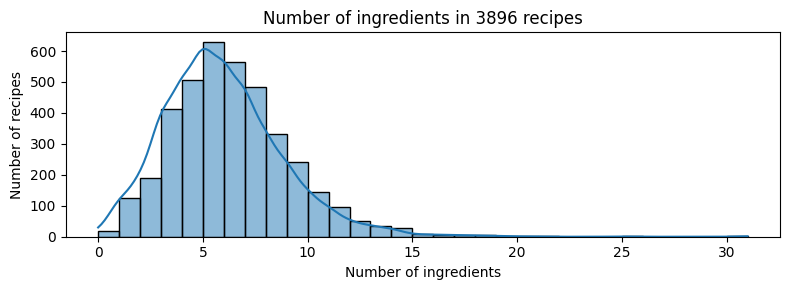

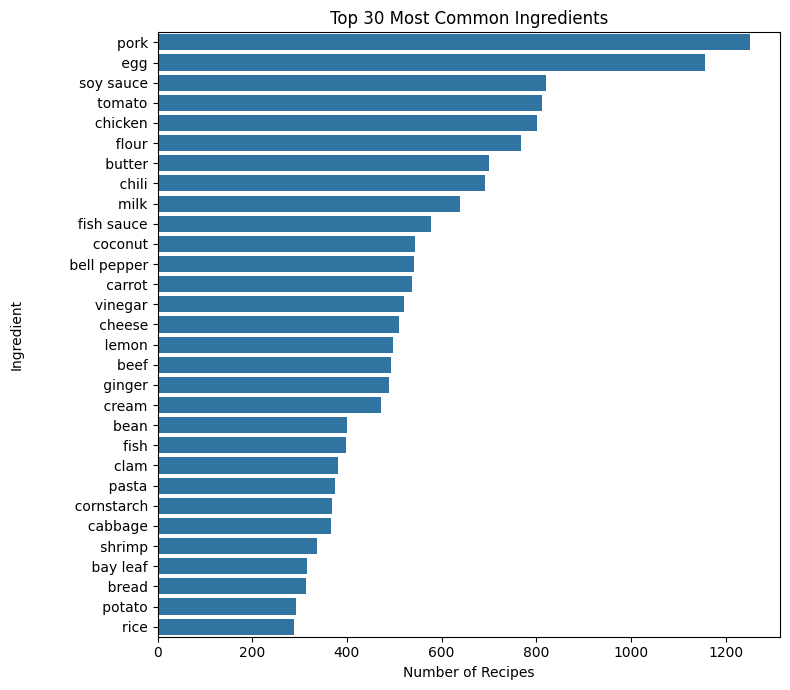

In [26]:
plot_ingredient_count_distribution(recipe_df.filtered_unique)
plot_common_ingredients(recipe_df.filtered_unique)

## Association Analysis

### Convert DataFrame to one-hot encoded format


In [27]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
one_hot = mlb.fit_transform(recipe_df.filtered_unique)
one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)
one_hot_df = one_hot_df.astype(bool)

one_hot_df.head()

,alcohol,anise,annatto,apple,asparagus,avocado,baking soda,banana,barbecue sauce,basil,...,tofu,tomato,turnip,vanilla,vegetable,vegetable broth,vinegar,wrapper,yam,yeast
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Find frequent itemsets


In [28]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(
    one_hot_df,
    min_support=0.01, #  Lower this value to get more frequent itemsets
    use_colnames=True,
)

frequent_itemsets.head()

,support,itemsets
0,0.047998,(alcohol)
1,0.013860,(anise)
2,0.021561,(annatto)
3,0.060062,(baking soda)
4,0.044661,(banana)


In [29]:
frequent_itemsets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   support   672 non-null    float64
 1   itemsets  672 non-null    object 
dtypes: float64(1), object(1)
memory usage: 10.6+ KB


### Generate association rules


In [30]:
from mlxtend.frequent_patterns import association_rules

rules_df = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.5,
)

rules_df.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(anise),(soy sauce),0.013860,0.196612,0.010267,0.740741,3.767527,0.007542,3.098783,0.744898
1,(annatto),(fish sauce),0.021561,0.145021,0.011294,0.523810,3.611968,0.008167,1.795457,0.739078
2,(baking soda),(butter),0.060062,0.161961,0.030031,0.500000,3.087163,0.020303,1.676078,0.719279
3,(baking soda),(egg),0.060062,0.268994,0.052875,0.880342,3.272721,0.036719,6.109123,0.738819
4,(baking soda),(flour),0.060062,0.174538,0.051848,0.863248,4.945902,0.041365,6.036191,0.848792


In [31]:
rules_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         543 non-null    object 
 1   consequents         543 non-null    object 
 2   antecedent support  543 non-null    float64
 3   consequent support  543 non-null    float64
 4   support             543 non-null    float64
 5   confidence          543 non-null    float64
 6   lift                543 non-null    float64
 7   leverage            543 non-null    float64
 8   conviction          543 non-null    float64
 9   zhangs_metric       543 non-null    float64
dtypes: float64(8), object(2)
memory usage: 42.6+ KB


In [32]:
rules_df["antecedents"] = rules_df["antecedents"].apply(tuple)
rules_df["consequents"] = rules_df["consequents"].apply(tuple)

rules_df.to_csv("data/association_rules.csv", index=False)

## Visualization

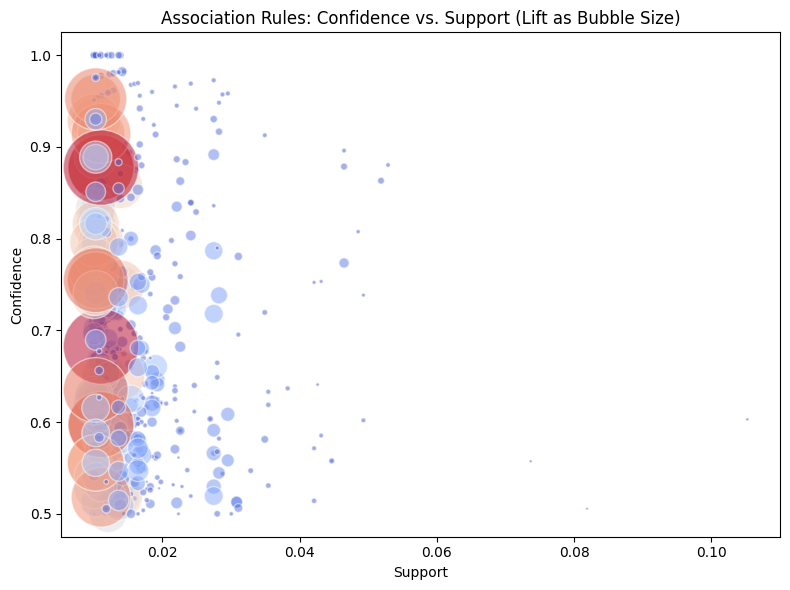

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(
    rules_df.support,
    rules_df.confidence,
    c=rules_df.lift,
    s=rules_df.lift**2,
    edgecolors="w",
    cmap="coolwarm",
    alpha=0.5,
)
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Association Rules: Confidence vs. Support (Lift as Bubble Size)")
plt.tight_layout()
plt.show()

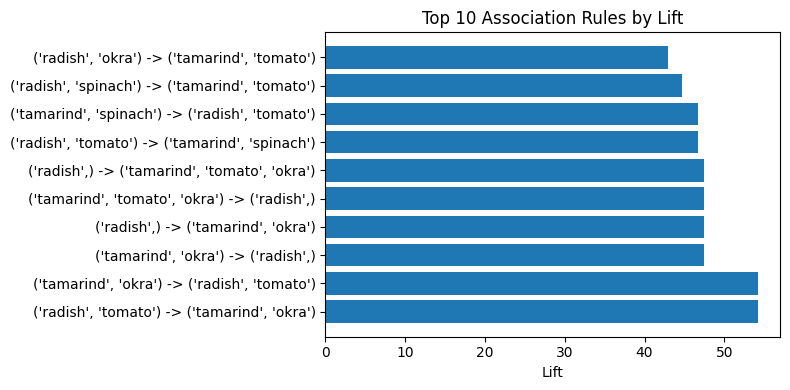

In [34]:
top_n = rules_df.nlargest(10, "lift")
plt.figure(figsize=(8, 4))
bars = plt.barh(
    top_n[["antecedents", "consequents"]].apply(
        lambda x: str(x.iloc[0]) + " -> " + str(x.iloc[1]), axis=1
    ),
    top_n["lift"],
)
plt.xlabel("Lift")
plt.title("Top 10 Association Rules by Lift")
plt.tight_layout()
plt.show()

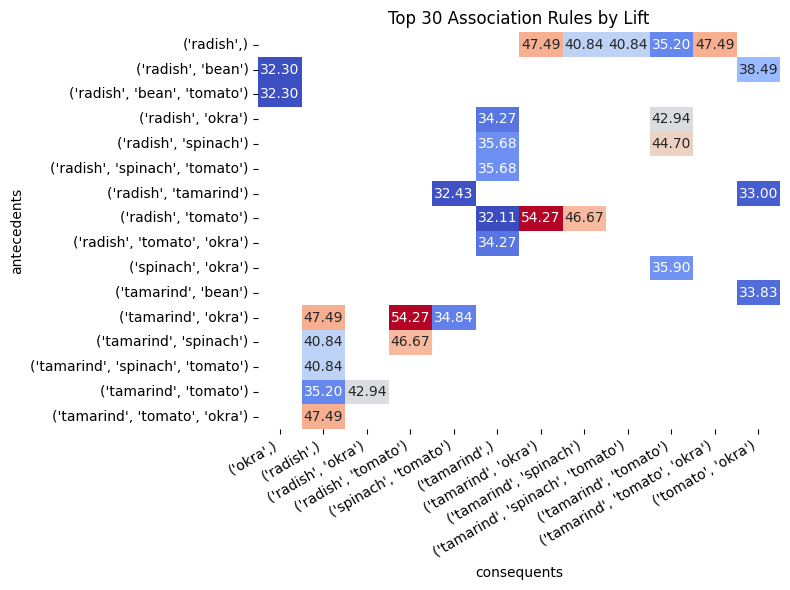

In [35]:
top_rules = rules_df.sort_values("lift", ascending=False).head(30)
pivot = top_rules.pivot(
    index="antecedents",
    columns="consequents",
    values="lift",
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title("Top 30 Association Rules by Lift")
plt.xticks(rotation=30, ha="right")

plt.tight_layout()
plt.show()

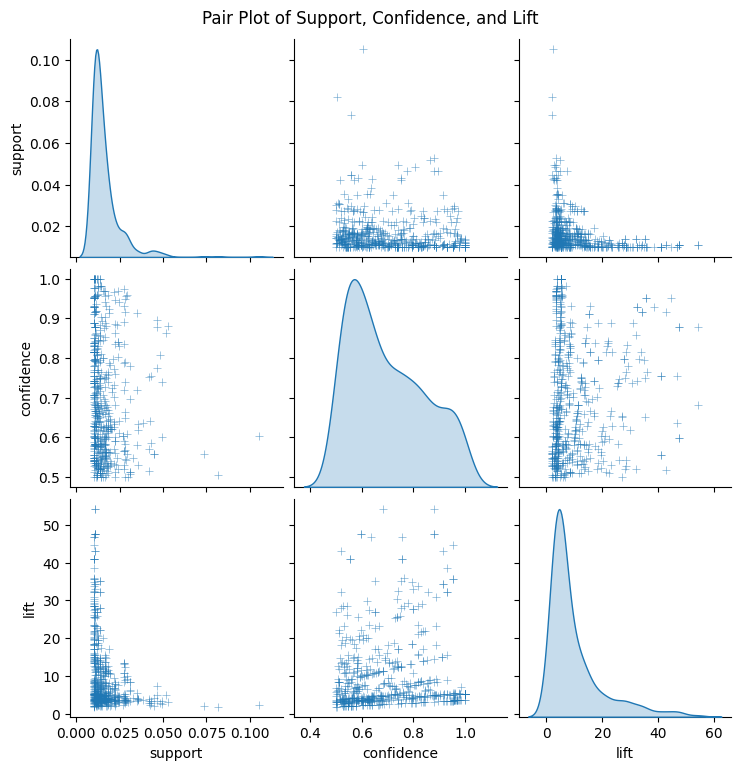

In [36]:
sns.pairplot(
    rules_df[["support", "confidence", "lift"]],
    diag_kind="kde",
    markers="+",
    plot_kws={"alpha": 0.6},
)
plt.suptitle("Pair Plot of Support, Confidence, and Lift", y=1.02)
plt.show()

In [37]:
import plotly.graph_objects as go
import networkx as nx

# Initialize graph and add edges from rules_df
G = nx.Graph()
for _, row in rules_df.iterrows():
    G.add_edge(
        str(row["antecedents"]),
        str(row["consequents"]),
        weight=row["lift"],
    )

# Compute spring layout for node positions
pos = nx.spring_layout(G, k=0.5, iterations=70)

# Prepare edge data for Plotly
edge_x = []
edge_y = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.3, color="#888"),
    hoverinfo="text",
    mode="lines",
)

# Calculate node degrees and prepare node hover text
node_degrees = dict(G.degree())
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]
node_texts = []
node_connections = {
    node: {"outgoing": [], "incoming": []} for node in G.nodes()
}

for edge in G.edges(data=True):
    node_connections[edge[0]]["outgoing"].append(edge[1])
    node_connections[edge[1]]["incoming"].append(edge[0])

for node in G.nodes():
    outgoing = node_connections[node]["outgoing"]
    incoming = node_connections[node]["incoming"]
    hover_text = (
        f"Node: {node}<br><br>"
        f"Consequent of ({len(incoming)}):<br>{'<br>'.join(incoming[:10])}<br><br>"
        f"Antecedent of ({len(outgoing)}):<br>{'<br>'.join(outgoing[:10])}"
    )
    node_texts.append(hover_text)
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers",
    text=node_texts,
    hoverinfo="text",
    marker=dict(size=10, line=dict(width=1, color="#222")),
)

# Create and display figure
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title="Association Rule Network Graph",
        titlefont_size=16,
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=20, r=20, t=40),
        annotations=[
            dict(text="", showarrow=False, xref="paper", yref="paper")
        ],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    ),
)
fig.show()